# Test computational cost of Stochastic Programming (Scenario Optimisation)

Investigate computational complexity and runtime of scnearios optimisation for system design problem, where each scenario uses a realisation of uncertain battery efficiencies.

In [1]:
import os
import csv
import json
import time
import random
import numpy as np
import matplotlib.pyplot as plt

import inspect
from tqdm import tqdm
from multiprocessing import Pool

from citylearn.citylearn import CityLearnEnv
from linmodel import LinProgModel
from schema_builder import build_schema
from sys_eval import evaluate_system

In [2]:
# set up test parameters
dataset_dir = os.path.join('A37_analysis_test') # dataset directory
schema_path = os.path.join('data', dataset_dir, 'schema.json')
opex_factor = 10
pricing_dict = {'carbon':5e-1,'battery':1e3,'solar':2e3}

with open(os.path.join(dataset_dir,'metadata_ext.json'),'r') as json_file:
    annex_defaults = json.load(json_file)

In [3]:
# Set up base parameters of system.
ids = [0,3,9,11,12,15,16,25,26,32,38,44,45,48,49]

In [4]:
num_buildings = range(1,len(ids)+1)
runtimes = {}

for B in num_buildings:
    print(f"# Buildings: {B}")

    base_kwargs = {
            'output_dir_path': os.path.join('data','A37_example_test'),
            'building_names': ['UCam_Building_%s'%id for id in ids][:B],
            'battery_energy_capacities': [annex_defaults["building_attributes"]["battery_energy_capacities (kWh)"][str(id)] for id in ids][:B],
            'battery_power_capacities': [annex_defaults["building_attributes"]["battery_power_capacities (kW)"][str(id)] for id in ids][:B],
            'battery_efficiencies': [0.85]*B,
            'pv_power_capacities': [annex_defaults["building_attributes"]["pv_power_capacities (kW)"][str(id)] for id in ids][:B],
            'load_data_paths': ['UCam_Building_%s.csv'%id for id in ids][:B],
            'weather_data_path': 'weather.csv',
            'carbon_intensity_data_path': 'carbon_intensity.csv',
            'pricing_data_path': 'pricing.csv',
            'schema_name': 'schema_temp'
        }

    schema_path = build_schema(**base_kwargs)

    # Initialise CityLearn environment object.
    env = CityLearnEnv(schema=schema_path)
    lp = LinProgModel(env=env)

    lp.set_time_data_from_envs()
    lp.generate_LP(clip_level='m',design=True,pricing_dict=pricing_dict,opex_factor=opex_factor)
    lp.set_LP_parameters()

    start = time.time()
    lp_results = lp.solve_LP(verbose=False,ignore_dpp=True)
    end = time.time()

    print(lp_results['battery_capacities'],lp_results['solar_capacities'])

    runtimes.update({B: end-start})
    print(f"Solve time: {round(runtimes[B],1)}s")

# Buildings: 1
[1101.16297146] [788.62322391]
Solve time: 9.8s
# Buildings: 2
[1098.18609437  925.01175676] [786.73055895 660.39262986]
Solve time: 52.1s
# Buildings: 3
[1091.31721299  920.09116263  826.25440659] [783.83661241 658.82426851 649.77327809]
Solve time: 169.0s
# Buildings: 4
[1096.33171439  922.8108577   826.8302492   683.9817335 ] [785.91060074 659.69112818 650.0087943  580.68120778]
Solve time: 307.9s
# Buildings: 5
[1094.77526954  922.8108577   826.62422388  686.24179945 2014.16602502] [ 785.22238164  659.69112818  649.27857646  574.54513298 1305.01112786]
Solve time: 482.4s
# Buildings: 6
[1093.78565858  923.113263    826.31701093  686.24179945 2011.92763392
 1636.63884428] [ 784.78480161  659.78751507  649.5834151   574.54513298 1304.40792885
 1113.88423435]
Solve time: 745.4s


In [5]:
# Fit linear trend to log(runtime)
trend = np.polyfit(np.log(list(runtimes.keys())),np.log(list(runtimes.values())),deg=1)
print(trend)

[2.43446182 2.31124001]


In [6]:
# Find max allowable samples
runtime_limit = 60*60*24*5
scenarios_limit = np.exp((np.log(runtime_limit) - trend[1])/trend[0])
print(scenarios_limit)

79.90358678511154


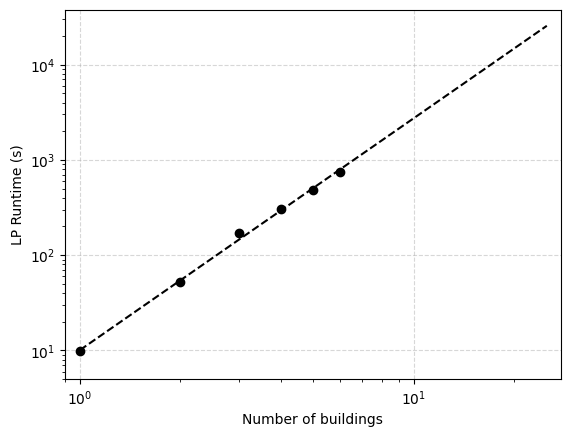

In [8]:
# Plot computational time results
max_scenarios = 25

plt.plot(runtimes.keys(),runtimes.values(),'ok')
plt.plot(np.arange(1,max_scenarios+1),np.exp(np.log(np.arange(1,max_scenarios+1))*trend[0] + trend[1]),'k--')
plt.xlabel("Number of buildings")
plt.xscale('log')
plt.ylabel('LP Solve Time (s)')
plt.yscale('log')
plt.xlim(0.9,max_scenarios*1.1)
plt.ylim(7)
plt.grid(True,'major',alpha=0.5,linestyle='--')
plt.show()